# Fit a transiting planet signal with a trapezoid model

Now, we'll use the photometry measurements we have just made for something exciting!

Monitoring the flux of a star might reveal the presence of a exoplanets when the planet "transits" across the front of the start as seen from our perspective. It causes a reduction of the apparent brightness of the star, and conducting large monitoring programs for the [transit method](https://en.wikipedia.org/wiki/Methods_of_detecting_exoplanets#Transit_photometry) has become one of the most successful methods to detect exoplanets.

We will use a simple model to describe the transit signal: a symmetric trapezoid. While it is geometrically simple, it is a non-linear model, that means you cannot write down a design matrix for it. So we need a more general minimizer to fit any given data. By the end of this notebook you will have all you need to fit transit data.

## Exercise 1

Write a function `read_data` that takes the object number (e.g. 7016.01) as an argument and returns two arrays: `time` and `flux`, read from the data file ('data/7016.01.txt').

In [161]:
import numpy as np
import matplotlib.pyplot as plt

In [162]:
def read_data(number):
    fname = 'data/' + str(number) + '.txt'
    time = np.loadtxt(fname=fname, usecols=0)
    flux = np.loadtxt(fname=fname, usecols=1)

    return time, flux

In [163]:
times, fluxes = read_data(7016.01)

Write a function `plot_data` that takes arrays for time and flux as arguments and plots time vs.
flux. Add axis labels. 

In [164]:
def plot_data(time, flux):
    plt.title('Flux vs Time')
    plt.scatter(time, flux)
    plt.xlabel('Time (s)')
    plt.ylabel('Flux (Jy)')
    plt.show()

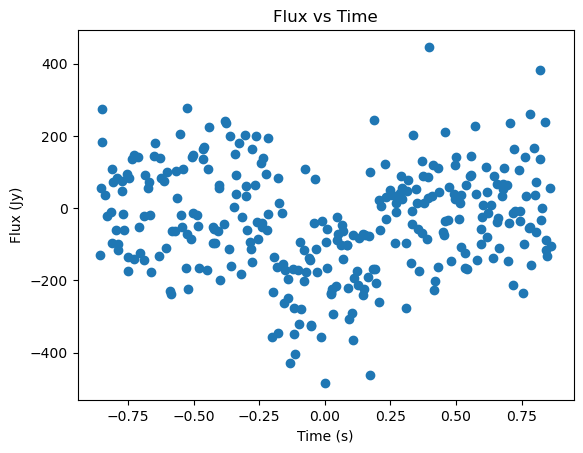

In [165]:
plot_data(times, fluxes)

## Exercise 2

Write a function `trapezoid` implementing the trapezoid model.  It should take four parameters:

* `delta` for the change in flux
* `T` for total duration
* `tau` for the ingress/egress duration
* `t0` for the central event time

and a time at which the trapezoid model is evaluated.

In [166]:
def trapezoid(delta, T, tau, t0, t):
    if (t < t0 - T/2): return 1
    elif (t < t0 - T/2 + tau): return 1 - delta * ((t - (t0 - T/2)) / tau)
    elif (t < t0 + T/2 - tau): return 1 - delta 
    elif (t < t0 + T/2): return 1 - delta * ((t0 + T/2 - t) / tau)
    return 1

To confirm that the model behaves as expected, make four different plots that show how the trapezoid shape changes when you vary each parameter independently (maybe 5 examples per plot).

In [167]:
t = np.linspace(-1, 1, 100)
delta, T, tau, t0 = [270, 1, 0.30, 0]
line = np.ones(len(t))

for i in range(len(t)):
    line[i] = trapezoid(delta, T, tau, t0, t[i])

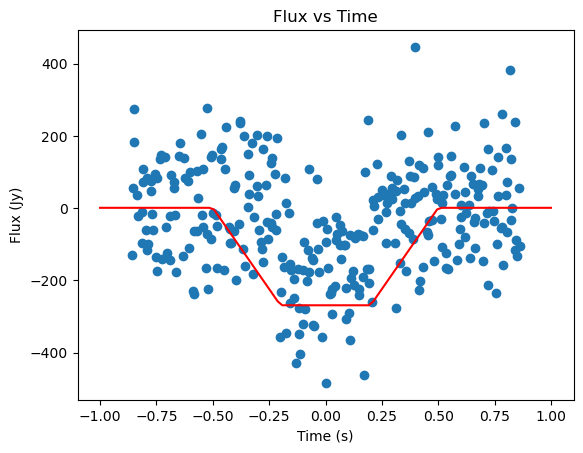

In [168]:
plt.title('Flux vs Time')
plt.scatter(times, fluxes)
plt.plot(t, line, color='red')
plt.xlabel('Time (s)')
plt.ylabel('Flux (Jy)')
plt.show()

## Exercise 3

Eyeball the plot of the actual 7016.01 transit signal, and try to guess what parameters might fit the data best.  Overplot the model on top of the data, and make a plot of the residuals (data - model) in a subplot.  Your
first guess doesn't have to be spot-on, the residuals should tell you where you're off the most.

In [169]:
model = np.ones(len(times))

for i in range(len(times)):
    model[i] = trapezoid(delta, T, tau, t0, times[i])

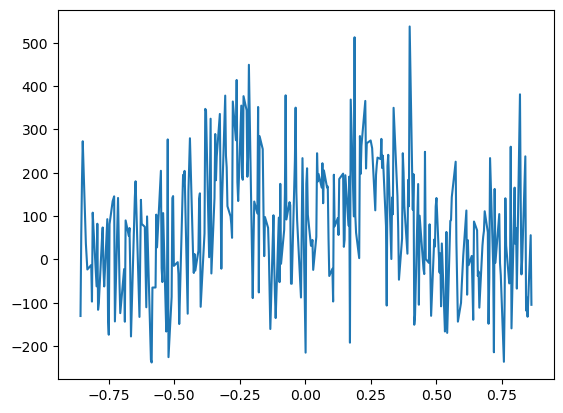

In [170]:
residuals = fluxes - model
plt.plot(times, residuals)

Use your best guess for the parameters to write a function `plot_fit` that takes the time and flux arrays and a parameter vector, and then makes the two plots: one with data and the  model, and another one with the residuals (i.e. data minus model).

## Exercise 4

Define the function `fit_trapezoid` that uses [scipy.optimize.minimize](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) to find the best-fit parameters for the 7016.01 data set, and display these results using `plot_fit`.

The function you want to minimize to find the "best-fit" parameters is the one that maximizes the likelihood. Since we're dealing with (assumed) Gaussian errors, this is the usual quadratic error form

$$
\chi^2(T,t_0,\tau,d;\ \lbrace (t_i,f_i) \rbrace) = \sum_i^N \frac{\left(f_i - \mathtt{trapezoid}(t_i;\ T,t_0,\tau,d)\right)^2}{\sigma_i^2},
$$

there $t_i$ and $f_i$ are the individual measurements of time and flux. The standard deviation of the measurements is $\sigma_i \approx 80$. 

Once you have the best-fit parameters, run `plot_fit` to visualize the result.

In [171]:
def trapezoid(params, t):
    
    if not np.isscalar(t):
        return np.array([trapezoid(params, t_) for t_ in t])
    
    delta, T, t0, tau = params
    t_ = t - t0
    if t_ < -T/2:
        return 0
    elif t_ < min(-T/2 + tau,0):
        slope = -delta / tau
        return slope * (t_ + T/2)
    elif t_ < max(0, T/2 - tau):
        return -delta
    elif t_ < T/2:
        slope = delta / tau
        return slope * (t_ - T/2)
    else:
        return 0

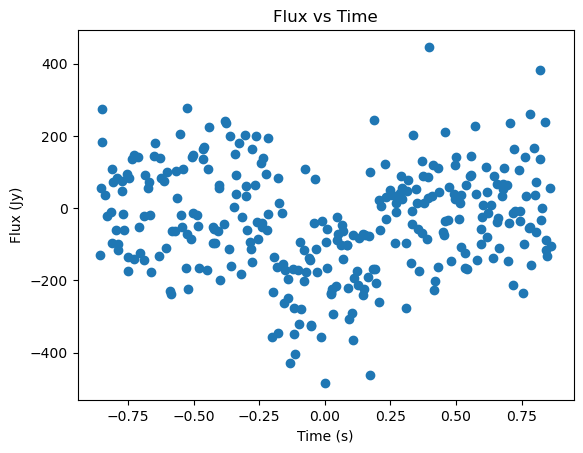

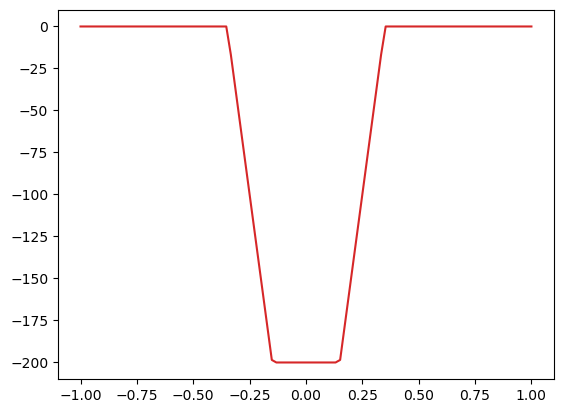

In [172]:
params = (200, 0.7, 0.0, 0.2)
model = trapezoid(params, t)

plot_data(times, fluxes)
plt.plot(t, model, color='C3')

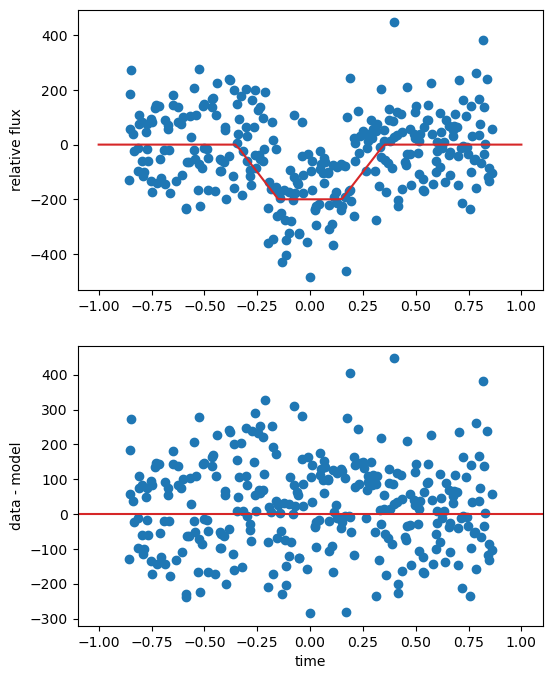

In [173]:
def plot_fit(time, flux, params):
    
    fig = plt.figure(figsize=(6,8))
    ax1 = fig.add_subplot(211)
    ax1.scatter(time, flux)
    
    t = np.linspace(-1, 1, 100)
    model = trapezoid(params, t)
    ax1.plot(t, model, color='C3')
    ax1.set_ylabel('relative flux')
    
    ax2 = fig.add_subplot(212, sharex=ax1)
    
    model_at_time = trapezoid(params, time)
    ax2.scatter(time, flux - model_at_time)
    ax2.axhline(0, color='C3')
    ax2.set_xlabel('time')
    ax2.set_ylabel('data - model')
    return ax
    
plot_fit(times, fluxes, params)


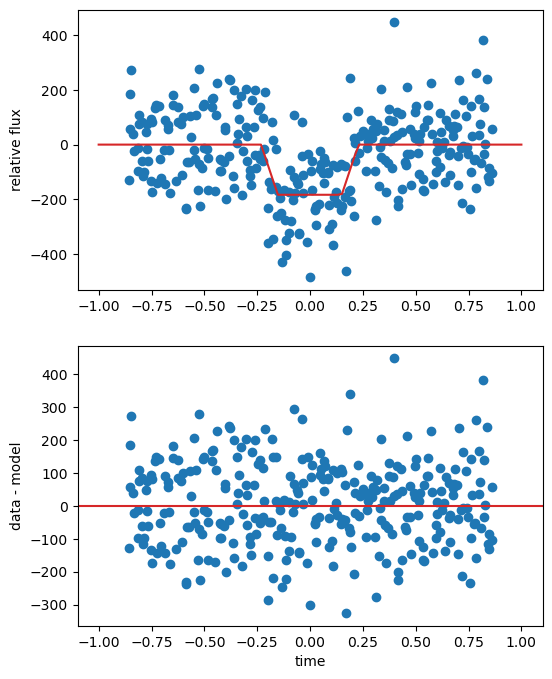

In [174]:
import scipy.optimize as so

def chi2(params, time, flux, stddev):
    model = trapezoid(params, time)
    return np.sum((model - flux)**2 / stddev**2)

def fit_trapezoid(params, time, flux, stddev):
    result = so.minimize(chi2, params, args=(time, flux, stddev))
    return result

stddev = 80
result = fit_trapezoid(params, times, fluxes, stddev)
plot_fit(times, fluxes, result.x)

With these best-fit parameters, we could now proceed to determine the parameters of the planet, in particular its radius, but also its orbital parameters...